In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

In [2]:
df = pd.read_csv('clean.csv')
df.head()

,author_ID,post,political_leaning,clean_post,nr_of_words,nr_of_characters,label
0,t2_kj8twzq5,dog (pic on my profile). Longer hair but other...,center,dog pic profile longer hair spot unfortunately...,774,4761,0
1,t2_1404zt,a skyscraper is probably gonna be mostly concr...,center,skyscraper probably gon na mostly concrete mea...,750,4791,0
2,t2_4erzxbrz,intentionally wash your ass are Poseidon's fre...,center,intentionally wash as poseidon french kiss bus...,741,4894,0
3,t2_ccx3o6,you will struggle. Still Jungle is a very simi...,center,struggle still jungle similar role support sin...,787,5261,0
4,t2_b19hyjws,kitlesini sevmezdim ama kral adammış Genj adam...,center,kitlesini sevmezdim ama kral adammış genj adam...,974,6428,0


In [3]:
df = df.drop(columns=['post', 'political_leaning'], axis=1)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df[['clean_post', 'nr_of_words', 'nr_of_characters']], 
                                                    df['label'], test_size=0.2, random_state=42)

In [15]:
from catboost.text_processing import Tokenizer

simple_tokenizer = Tokenizer()

def tokenize_texts(texts):
    return [simple_tokenizer.tokenize(text) for text in texts]

tokenizer = Tokenizer(
    lowercasing=True,
    separator_type='BySense',
    token_types=['Word', 'Number']
)


stop_words = set(('be', 'is', 'are', 'the', 'an', 'of', 'and', 'in'))

def filter_stop_words(tokens):
    return list(filter(lambda x: x not in stop_words, tokens))

import nltk

# nltk_data_path = os.path.join(os.path.dirname(nltk.__file__), 'nltk_data')
# nltk.data.path.append(nltk_data_path)
# nltk.download('wordnet', nltk_data_path)

lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_tokens_nltk(tokens):
    return list(map(lambda t: lemmatizer.lemmatize(t), tokens))

In [16]:
from catboost import Pool


def preprocess_data(X):
    X_preprocessed = X.copy()
    X_preprocessed['clean_post'] = X['clean_post'].apply(lambda x: ' '.join(lemmatize_tokens_nltk(tokenizer.tokenize(x))))
    return X_preprocessed

X_preprocessed_train = preprocess_data(X_train)
X_preprocessed_test = preprocess_data(X_test)

train_processed_pool = Pool(
    X_preprocessed_train, y_train, 
    text_features=['clean_post'],
)

test_processed_pool = Pool(
    X_preprocessed_test, y_test, 
    text_features=['clean_post'],
)

In [17]:
from catboost import CatBoostClassifier, Pool

# Prepare data
text_features = ['clean_post']
numeric_features = ['nr_of_words', 'nr_of_characters']

# train_pool = Pool(data=X_train, label=y_train, text_features=text_features)
# test_pool = Pool(data=X_test, label=y_test, text_features=text_features)

# Train CatBoost Classifier
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    text_processing='BoW',  # Bag of Words for text features
    random_seed=42
)

model.fit(train_processed_pool, eval_set=test_processed_pool, verbose=100)

0:	learn: 1.0456294	test: 1.0411848	best: 1.0411848 (0)	total: 175ms	remaining: 1m 27s
100:	learn: 0.7393664	test: 0.7066214	best: 0.7066214 (100)	total: 23.1s	remaining: 1m 31s
200:	learn: 0.6778776	test: 0.6725464	best: 0.6725464 (200)	total: 45.4s	remaining: 1m 7s
300:	learn: 0.6325684	test: 0.6497236	best: 0.6497236 (300)	total: 1m 8s	remaining: 45s
400:	learn: 0.5928019	test: 0.6317923	best: 0.6317923 (400)	total: 1m 32s	remaining: 22.7s
499:	learn: 0.5578886	test: 0.6167446	best: 0.6167446 (499)	total: 1m 56s	remaining: 0us

bestTest = 0.6167446104
bestIteration = 499



In [18]:
importance = model.get_feature_importance(train_processed_pool, type='Interaction')
for feature, score in zip(X_train.columns, importance):
    print(f"{feature}: {score}")
print("\n")

clean_post: [1.         2.         0.01477916]




In [19]:
importance

array([[1.        , 2.        , 0.01477916]])

In [ ]:
for class_id, label in enumerate(['center', 'left', 'right']):
    importance = model.get_feature_importance(train_pool, type='Interaction', class_id=class_id)
    print(f"Feature Importance for label '{label}':")
    for feature, score in zip(X_train.columns, importance):
        print(f"{feature}: {score}")
    print("\n")

In [ ]:
for class_id, label in enumerate(['center', 'left', 'right']):
    importance = model.get_feature_importance(train_pool, type='PredictionValuesChange', class_id=class_id)
    print(f"Feature Importance for label '{label}':")
    for feature, score in zip(feature_names, importance):
        print(f"{feature}: {score}")
    print("\n")


In [ ]:
global_importance = model.get_feature_importance(train_pool, type='PredictionValuesChange')
print("Global Feature Importance:")
for feature, score in zip(feature_names, global_importance):
    print(f"{feature}: {score}")


In [ ]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer(train_processed_pool)

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=0]="penis think luckily government experience forcing japanese thing politician hypocrite shocked prosecuted hiding corpse actually fact done make good headline gt trapped work gt leave lmao redditor reading comprehension oh geez guess stop thanks happened many time coincidence taylor incompetence clear agenda every time taylor officiates match literally ban bridge saying go high idea know taylor dean seem seriously something u push someone away within arm reach season 11 episode 6 peter checking trash compactor guy apartment fuck dude hit way close home sweet sweet endorphin waterspout happen time talking lot someone like smoke pot lmao racing incident pal byron take people win race lmfao side side bus stop racing hard shit happens lmao everyone mad ty like loved role reversed racing incident bro relax imagine mad 19 year old kid lmao get life sure role reversed still pissed ty lmfao bro racing incident relax happened byron run wide turn 1 shit happens byron could given room bus stop expect ty back corner racing win literally opposed old problem plenty motivated solve fuel stabilizer fix issue sweat moving young adult western phenomenon anyway weekly boneheaded move chastain chastain even 1 race year involved incident way past ridiculous point give one guess 99 1 dude running 10 got taking chastain kiki great day also happens careless driver traffic every week coincidence involved sort wreck every race shit great awful one lap chastained fixing container gas go bad regardless color container lighter make happen little quicker container absolutely rated fuel please 9 begging dude careless need learn race pack cold day hell 9 get penalized gibbs driving kurt car definitely way comfortable nascar environment think f1 formal super laid back lmao happens best u buddy fucking hell looked away one second 1 spin cold custard disappearing road rn shame purple scheme pretty get beat much shame running well day everything probably listen propane commercial unless star hank hill man race trope huh chastain moment ware spin elliot dominating kb implosion classic nascar first time ever rooting chastain lmao pain cawshun yeah throw yellow barrier messed like well shit cawshun lmao tow truck wanting back gravel funny idk clusterfuck incoming good chance get like 3 4 yellow said done understand hate car go fast fun form jimmie dong dinger hugh mungus ding donger let go damn larson good planned lock sure 9 flair bitching like elliot routinely make move always alright golden boy seems like good author comedian musician end killing real probably still went cape canaveral far disney look like grab right underneath swing wanted sleep stuck friend zone would moved hemric spotter way someone told clear throw block 9 fr got shit turn tell hwat man talkin bout dang ol bottom lane man better jump uhhh wtf happened jesus christ finish lap 4 hour knew turned race one shocked stenhouse least partially responsible massive wreck fucking mess race got really bad feeling still got wreck one jeff burton mention damaged car 5 second challenge contact 2 restarts lmfao fucking knew oh god sleep tonight please holy shit gragson gon na feel morning would cut toe watching chucky shit know dale hurting inside thinking money gon na spend sure dinger fucking furious murphy law 250 daytona redone restart everyone behind 21 got fucked shitty ending restarted behind 21 race end like choice word nascar rock throw whoever came one nice broke like month second time seems like banner often last 5 year placebo lmao bet stopped less 5 total suicide hot hamburg sandwich equal hot pull fuck nuanced reddit user odds mattia get fired year unpopular literally ever post cart full people hating lmfao hilarious joke tell guy pal make joke body shaming bad done woman report cyber police suppose sure cia director always tell truth periodically progressive reverse engineer healthy sexual behavior act like discovered atlantis would agree french ground long agree frenchman finally animal relate yeah hear chevy gon na sell car amc year lmfao lewis perfect angel pull shit much anyone else please find championship winning driver never done point valid gt seriously thought child entertainment company would let dude dan schneider entered chat could possibly pixel chastain cause wreck challenge impossible lmao shitty pit crew lmao crocodile tear chastain every week saying got ta change keep pulling shit definitely balance aggressive without spinning dude constantly boring end great race unfortunate great depression 30 though worry get worse glad guy bent knee admins like make much funnier sub get banned anyway next sure ron paul banned originally star war supposed story told whills sorta like deity iirc opposite fascism lmfao casually advocating literal infanticide lmfao reddit would argue murdering innocent child bad like ask berry spotter question save mayer lmao 100 kirkwood fault yes move never going stick went": Cannot convert 'b'penis think luckily government experience forcing japanese thing politician hypocrite shocked prosecuted hiding corpse actually fact done make good headline gt trapped work gt leave lmao redditor reading comprehension oh geez guess stop thanks happened many time coincidence taylor incompetence clear agenda every time taylor officiates match literally ban bridge saying go high idea know taylor dean seem seriously something u push someone away within arm reach season 11 episode 6 peter checking trash compactor guy apartment fuck dude hit way close home sweet sweet endorphin waterspout happen time talking lot someone like smoke pot lmao racing incident pal byron take people win race lmfao side side bus stop racing hard shit happens lmao everyone mad ty like loved role reversed racing incident bro relax imagine mad 19 year old kid lmao get life sure role reversed still pissed ty lmfao bro racing incident relax happened byron run wide turn 1 shit happens byron could given room bus stop expect ty back corner racing win literally opposed old problem plenty motivated solve fuel stabilizer fix issue sweat moving young adult western phenomenon anyway weekly boneheaded move chastain chastain even 1 race year involved incident way past ridiculous point give one guess 99 1 dude running 10 got taking chastain kiki great day also happens careless driver traffic every week coincidence involved sort wreck every race shit great awful one lap chastained fixing container gas go bad regardless color container lighter make happen little quicker container absolutely rated fuel please 9 begging dude careless need learn race pack cold day hell 9 get penalized gibbs driving kurt car definitely way comfortable nascar environment think f1 formal super laid back lmao happens best u buddy fucking hell looked away one second 1 spin cold custard disappearing road rn shame purple scheme pretty get beat much shame running well day everything probably listen propane commercial unless star hank hill man race trope huh chastain moment ware spin elliot dominating kb implosion classic nascar first time ever rooting chastain lmao pain cawshun yeah throw yellow barrier messed like well shit cawshun lmao tow truck wanting back gravel funny idk clusterfuck incoming good chance get like 3 4 yellow said done understand hate car go fast fun form jimmie dong dinger hugh mungus ding donger let go damn larson good planned lock sure 9 flair bitching like elliot routinely make move always alright golden boy seems like good author comedian musician end killing real probably still went cape canaveral far disney look like grab right underneath swing wanted sleep stuck friend zone would moved hemric spotter way someone told clear throw block 9 fr got shit turn tell hwat man talkin bout dang ol bottom lane man better jump uhhh wtf happened jesus christ finish lap 4 hour knew turned race one shocked stenhouse least partially responsible massive wreck fucking mess race got really bad feeling still got wreck one jeff burton mention damaged car 5 second challenge contact 2 restarts lmfao fucking knew oh god sleep tonight please holy shit gragson gon na feel morning would cut toe watching chucky shit know dale hurting inside thinking money gon na spend sure dinger fucking furious murphy law 250 daytona redone restart everyone behind 21 got fucked shitty ending restarted behind 21 race end like choice word nascar rock throw whoever came one nice broke like month second time seems like banner often last 5 year placebo lmao bet stopped less 5 total suicide hot hamburg sandwich equal hot pull fuck nuanced reddit user odds mattia get fired year unpopular literally ever post cart full people hating lmfao hilarious joke tell guy pal make joke body shaming bad done woman report cyber police suppose sure cia director always tell truth periodically progressive reverse engineer healthy sexual behavior act like discovered atlantis would agree french ground long agree frenchman finally animal relate yeah hear chevy gon na sell car amc year lmfao lewis perfect angel pull shit much anyone else please find championship winning driver never done point valid gt seriously thought child entertainment company would let dude dan schneider entered chat could possibly pixel chastain cause wreck challenge impossible lmao shitty pit crew lmao crocodile tear chastain every week saying got ta change keep pulling shit definitely balance aggressive without spinning dude constantly boring end great race unfortunate great depression 30 though worry get worse glad guy bent knee admins like make much funnier sub get banned anyway next sure ron paul banned originally star war supposed story told whills sorta like deity iirc opposite fascism lmfao casually advocating literal infanticide lmfao reddit would argue murdering innocent child bad like ask berry spotter question save mayer lmao 100 kirkwood fault yes move never going stick went'' to float

In [24]:
shap.plots.force(shap_values[0, ...])


TypeError: 'Pool' object is not subscriptable

XGBoost

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize text
tfidf = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf.fit_transform(X_train['clean_post']).toarray()
X_test_tfidf = tfidf.transform(X_test['clean_post']).toarray()

# Combine with numeric features
import numpy as np
X_train_combined = np.hstack([X_train_tfidf, X_train[['nr_of_words', 'nr_of_characters']].values])
X_test_combined = np.hstack([X_test_tfidf, X_test[['nr_of_words', 'nr_of_characters']].values])


In [70]:
import xgboost as xgb

# Convert data to DMatrix
dtrain = xgb.DMatrix(X_train_combined, label=y_train)
dtest = xgb.DMatrix(X_test_combined, label=y_test)

# Train the model
params = {
    'objective': 'multi:softmax',  # Multi-class classification
    'num_class': 3,               # Number of classes (center, left, right)
    'max_depth': 6,
    'eta': 0.3,
    'eval_metric': 'mlogloss',
    'seed': 42
}

evals_result = {}

model = xgb.train(params, dtrain, num_boost_round=500, evals=[(dtest, 'test')], early_stopping_rounds=50, evals_result=evals_result)


[0]	test-mlogloss:1.07891
[1]	test-mlogloss:1.06251
[2]	test-mlogloss:1.04850
[3]	test-mlogloss:1.03599
[4]	test-mlogloss:1.02428
[5]	test-mlogloss:1.01298
[6]	test-mlogloss:1.00161
[7]	test-mlogloss:0.99255
[8]	test-mlogloss:0.98384
[9]	test-mlogloss:0.97660
[10]	test-mlogloss:0.96819
[11]	test-mlogloss:0.95883
[12]	test-mlogloss:0.95204
[13]	test-mlogloss:0.94571
[14]	test-mlogloss:0.93849
[15]	test-mlogloss:0.93229
[16]	test-mlogloss:0.92692
[17]	test-mlogloss:0.92126
[18]	test-mlogloss:0.91598
[19]	test-mlogloss:0.91015
[20]	test-mlogloss:0.90457
[21]	test-mlogloss:0.89958
[22]	test-mlogloss:0.89450
[23]	test-mlogloss:0.88954
[24]	test-mlogloss:0.88552
[25]	test-mlogloss:0.88056
[26]	test-mlogloss:0.87584
[27]	test-mlogloss:0.87214
[28]	test-mlogloss:0.86722
[29]	test-mlogloss:0.86358
[30]	test-mlogloss:0.85994
[31]	test-mlogloss:0.85659
[32]	test-mlogloss:0.85235
[33]	test-mlogloss:0.84951
[34]	test-mlogloss:0.84678
[35]	test-mlogloss:0.84237
[36]	test-mlogloss:0.83855
[37]	test-m

In [72]:
# Access the evaluation history
print(evals_result['test'])
# For example, if using accuracy:
#print(evals_result['test']['accuracy'])  # List of accuracy values for each iteration

OrderedDict({'mlogloss': [1.0789098532995665, 1.062512310064214, 1.0484959154173634, 1.0359947121704154, 1.0242813856516704, 1.0129777554285242, 1.0016076407615508, 0.9925470192676284, 0.9838380762588015, 0.9766034867408445, 0.968188149892925, 0.9588262081134119, 0.9520385751658303, 0.9457080202710506, 0.9384883013321592, 0.9322885283634649, 0.9269182355569396, 0.921258426806738, 0.9159766244045469, 0.9101499991083352, 0.9045733495084104, 0.8995767486495837, 0.8945028772133194, 0.8895419683436704, 0.8855235963684068, 0.8805632557156304, 0.8758406547704255, 0.8721407189936965, 0.8672163133254909, 0.8635828476722419, 0.8599389833044624, 0.856586415648921, 0.85234746010469, 0.8495148452970557, 0.8467768911058143, 0.842373217820693, 0.8385475457740903, 0.8350149364505618, 0.8321372370736637, 0.8292299817708157, 0.8265066686138882, 0.8232702539472108, 0.8210374039401848, 0.817174708378782, 0.8142850723086277, 0.8116724309567039, 0.8089624552516804, 0.8059759545660176, 0.8024309147265487, 0.

In [73]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(dtest)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 78.10%


In [67]:
from sklearn.metrics import accuracy_score

# Predict on the test set
y_pred = model.predict(dtest)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Assuming dtest contains the true labels
true_labels = dtest.get_label()

# Calculate accuracy
accuracy = accuracy_score(true_labels, y_pred_labels)
print("Accuracy:", accuracy)

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
# from sklearn.inspection import permutation_importance
# import pandas as pd


# # Function to get permutation importance for each class
# def get_permutation_importance_for_class(model, X_test, y_test, class_id):
#     # First, create a mask for the target class in the y_test (the true labels)
#     y_test_class = (y_test == class_id).astype(int)
    
#     # Calculate permutation importance on the test data for the given class
#     result = permutation_importance(model, X_test, y_test_class, n_repeats=10, random_state=42, n_jobs=-1)
    
#     # Get importance scores
#     importance = result.importances_mean
    
#     return importance

# # Now calculate permutation importance for each class
# for class_id, label in enumerate(['center', 'left', 'right']):
#     print(f"Permutation Importance for label '{label}':")
    
#     # Get importance values for the current class
#     importance_scores = get_permutation_importance_for_class(model, X_test, y_test, class_id)
    
#     # Get the feature names (you should already have this list)
#     feature_names = list(tfidf.get_feature_names_out()) + ['nr_of_words', 'nr_of_characters']
    
#     # Print the top 10 features by importance for the current label
#     top_features = sorted(zip(feature_names, importance_scores), key=lambda x: x[1], reverse=True)[:10]
    
#     for feature, score in top_features:
#         print(f"{feature}: {score}")
#     print("\n")


Permutation Importance for label 'center':


InvalidParameterError: The 'estimator' parameter of permutation_importance must be an object implementing 'fit'. Got <xgboost.core.Booster object at 0x000001D82448D8E0> instead.

In [28]:
# Get feature importance using 'gain'
importance = model.get_score(importance_type='gain')

# Sort the features by importance score in descending order and get top 10
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:10]

# Get the feature names from tf-idf
tfidf_feature_names = tfidf.get_feature_names_out()

# Combine with other numeric features
numeric_feature_names = ['nr_of_words', 'nr_of_characters']

# Combine all feature names
feature_names = list(tfidf_feature_names) + numeric_feature_names

# Print top 10 features with their importance scores
print("Top 10 Features by Importance:")
for feature_code, score in sorted_importance:
    # Extract the feature index from the code (e.g., f255 -> 255)
    feature_idx = int(feature_code[1:])  # Remove 'f' and convert to integer
    
    # Check if the feature code corresponds to a text feature or numeric feature
    if feature_idx < len(tfidf_feature_names):  # Text feature
        feature_name = tfidf_feature_names[feature_idx]
    else:  # Numeric feature (based on the position in the combined list)
        feature_name = numeric_feature_names[feature_idx - len(tfidf_feature_names)]

    print(f"{feature_name}: {score}")




Top 10 Features by Importance:
du: 9.214069366455078
government: 7.358835697174072
capitalism: 7.201832294464111
deck: 7.1543097496032715
che: 6.720594882965088
gun: 6.1131672859191895
der: 5.58093786239624
king: 5.526099681854248
haha: 5.218601703643799
stock: 5.083409309387207


In [29]:
explainer = shap.TreeExplainer(model)
explanation = explainer(dtrain)

shap_values = explanation.values

In [41]:
type(shap_values)

numpy.ndarray

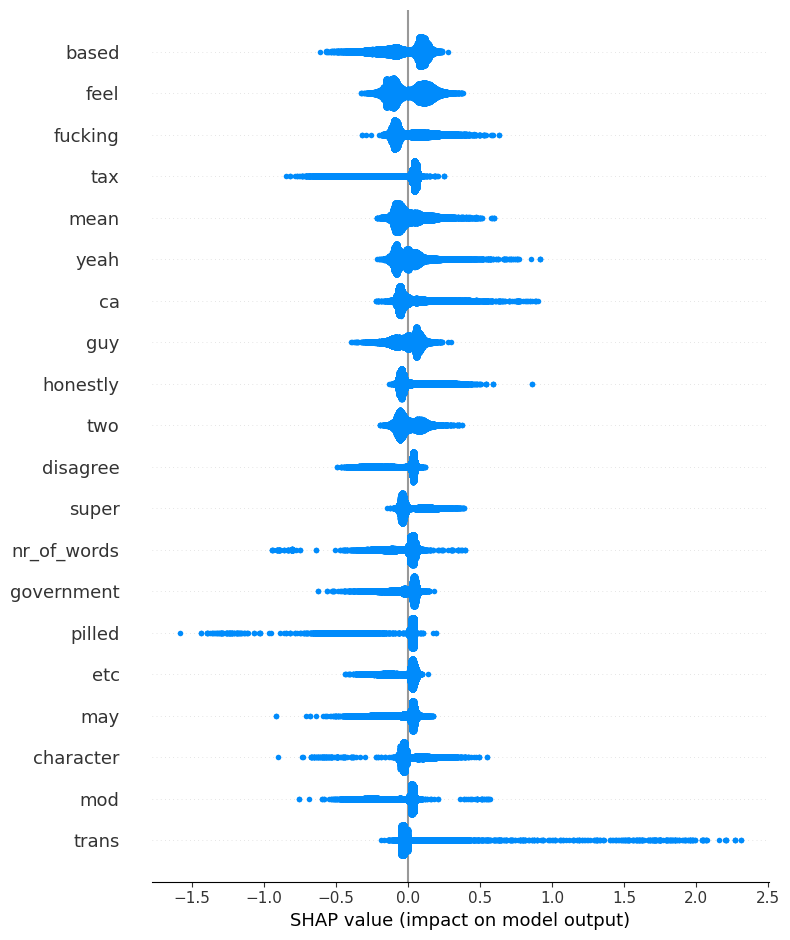

In [50]:
shap.summary_plot(shap_values[:,:,1],feature_names=feature_names)

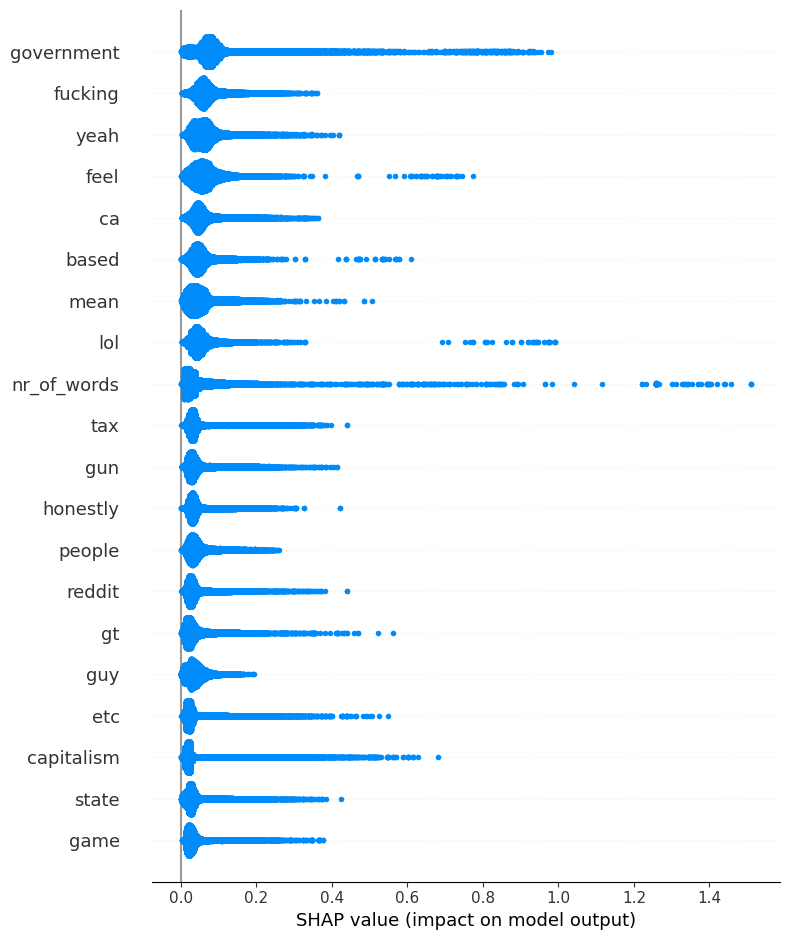

In [52]:
shap_values_aggregated = np.mean(np.abs(shap_values), axis=2)
shap.summary_plot(shap_values_aggregated, feature_names=feature_names)

In [53]:
shap_values_aggregated

array([[1.6552599e-02, 4.8285890e-03, 3.5328264e-04, ..., 8.3179241e-03,
        3.2545526e-02, 3.8041405e-02],
       [7.3328502e-03, 1.8054264e-03, 2.9925583e-04, ..., 9.8581500e-03,
        1.4664031e-02, 9.4540427e-03],
       [6.7077032e-03, 2.1902455e-03, 2.6952615e-04, ..., 1.0246049e-02,
        2.1145828e-01, 4.0085778e-02],
       ...,
       [1.4348108e-02, 4.2425445e-03, 2.7770406e-04, ..., 7.6868609e-03,
        1.9824876e-02, 3.6799118e-03],
       [1.5804455e-02, 5.0050379e-03, 1.9060560e-04, ..., 4.6179939e-02,
        2.0512687e-02, 1.4121528e-02],
       [1.2828150e-02, 2.3004615e-03, 4.1300323e-04, ..., 3.1636711e-02,
        2.1367053e-02, 1.8436665e-02]], dtype=float32)

In [59]:
# Step 1: Aggregate SHAP values across samples for each feature and label
shap_aggregated = {}
for label_idx in range(n_labels):
    shap_aggregated[label_idx] = np.mean(np.abs(shap_values[:, :, label_idx]), axis=0)

In [60]:
shap_aggregated

{0: array([0.01358967, 0.00629575, 0.00107523, ..., 0.0070818 , 0.0527364 ,
        0.01470812], dtype=float32),
 1: array([0.00698793, 0.00255653, 0.00035364, ..., 0.03594259, 0.0584012 ,
        0.02504354], dtype=float32),
 2: array([0.02161543, 0.01482587, 0.0009825 , ..., 0.00314769, 0.04904867,
        0.02747275], dtype=float32)}

In [69]:
# Assuming shap_aggregated contains the aggregated SHAP values (n_labels x n_features)
# and feature_names contains the corresponding words (features)

n_labels = shap_values.shape[2]

feature_names = list(tfidf_feature_names) + numeric_feature_names

# Assuming shap_aggregated contains the aggregated SHAP values (n_labels x n_features)
# and feature_names contains the corresponding words (features)

biased_words = {label: [] for label in range(n_labels)}

# Define a relative difference threshold (e.g., 20%)
relative_threshold = 1

for word_idx, word in enumerate(feature_names):
    scores = {label: shap_aggregated[label][word_idx] for label in range(n_labels)}

    for label in scores:
        other_labels = [l for l in scores if l != label]
        max_other_score = max([scores[l] for l in other_labels], default=0)

        # Compute the relative difference
        if max_other_score > 0:  # Avoid division by zero
            relative_diff = (scores[label] - max_other_score) / max_other_score
        else:
            relative_diff = float('inf')  # Treat as infinitely biased if others are zero

        # Check if it exceeds the threshold
        if relative_diff > relative_threshold:
            biased_words[label].append((word, scores[label], max_other_score, relative_diff))

# Sort biased words for each label by relative difference in descending order
for label in biased_words:
    biased_words[label].sort(key=lambda x: x[3], reverse=True)  # Sort by relative_diff (4th element in tuple)

# Output biased words for each label
for label, words in biased_words.items():
    print(f"\nBiased words for label {label}:")
    for word, label_score, max_other_score, relative_diff in words:
        print(f"  {word} - Label Score: {label_score:.6f}, Max Other Score: {max_other_score:.6f}, Relative Difference: {relative_diff:.2%}")




Biased words for label 0:
  born - Label Score: 0.021937, Max Other Score: 0.000937, Relative Difference: 2242.20%
  eventually - Label Score: 0.020750, Max Other Score: 0.001077, Relative Difference: 1827.24%
  similar - Label Score: 0.039934, Max Other Score: 0.003294, Relative Difference: 1112.26%
  concept - Label Score: 0.016424, Max Other Score: 0.001563, Relative Difference: 950.90%
  cool - Label Score: 0.026819, Max Other Score: 0.002782, Relative Difference: 864.01%
  mental - Label Score: 0.017970, Max Other Score: 0.001944, Relative Difference: 824.22%
  easier - Label Score: 0.015052, Max Other Score: 0.002102, Relative Difference: 615.96%
  hey - Label Score: 0.015715, Max Other Score: 0.002250, Relative Difference: 598.38%
  entire - Label Score: 0.064298, Max Other Score: 0.010171, Relative Difference: 532.18%
  drive - Label Score: 0.016388, Max Other Score: 0.002637, Relative Difference: 521.50%
  massive - Label Score: 0.013157, Max Other Score: 0.002211, Relative D

C:\Users\arina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Computing SHAP values for label 'center'...


Computing SHAP for center: 100%|██████████| 7376/7376 [00:16<00:00, 446.12it/s]


Completed SHAP values for center. Time elapsed: 16.54 seconds.
Computing SHAP values for label 'left'...


Computing SHAP for left: 100%|██████████| 7376/7376 [00:18<00:00, 392.98it/s]


Completed SHAP values for left. Time elapsed: 35.31 seconds.
Computing SHAP values for label 'right'...


Computing SHAP for right: 100%|██████████| 7376/7376 [00:18<00:00, 394.84it/s]


Completed SHAP values for right. Time elapsed: 53.99 seconds.
SHAP Summary for label 'center':


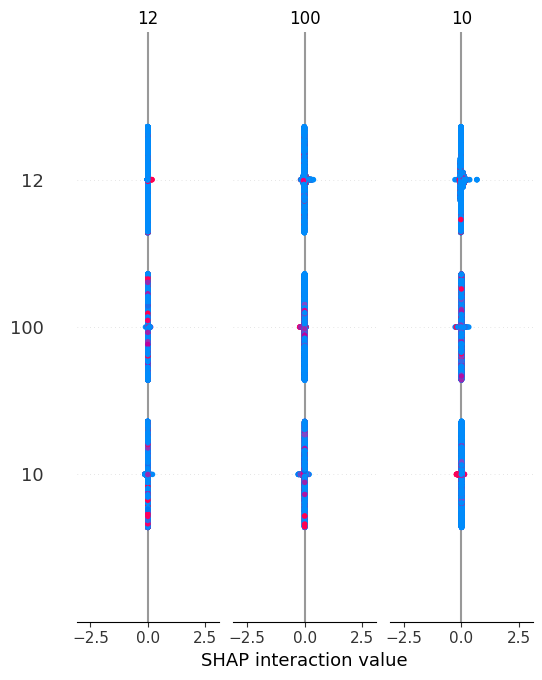

SHAP Summary for label 'left':


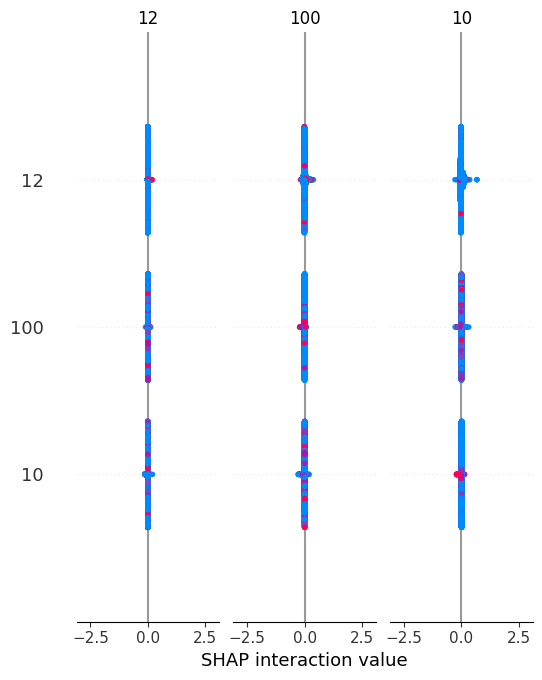

SHAP Summary for label 'right':


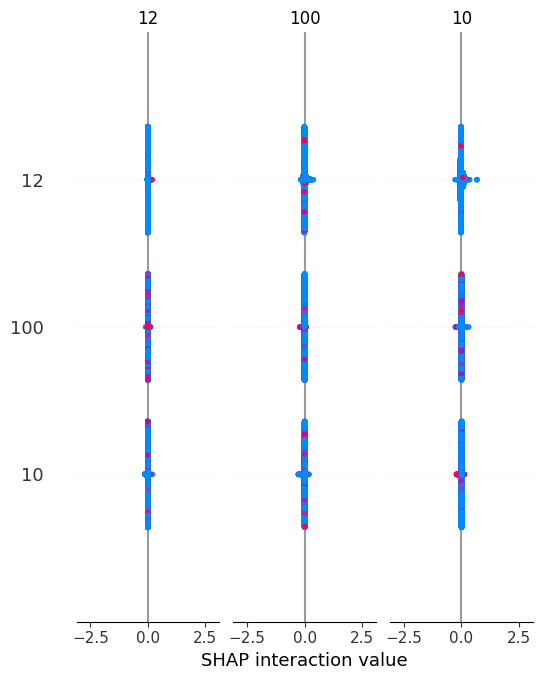

In [ ]:
import shap
from tqdm import tqdm
import time

# Load SHAP explainer
explainer = shap.TreeExplainer(model)

# Define the list of labels
labels = ['center', 'left', 'right']

# Compute SHAP values for test data
shap_values = []

# Start the timer
start_time = time.time()

# Compute SHAP values for each class
for class_id, label in enumerate(labels):
    print(f"Computing SHAP values for label '{label}'...")

    # Add tqdm progress bar to monitor progress
    # The 'shap_values[class_id]' will be computed one by one in the loop
    tqdm_bar = tqdm(total=len(X_test_combined), desc=f"Computing SHAP for {label}", position=0)

    # Compute SHAP values with progress tracking
    shap_values_class = explainer.shap_values(X_test_combined)
    
    # Updating progress
    tqdm_bar.update(len(X_test_combined))
    
    shap_values.append(shap_values_class)
    tqdm_bar.close()

    # Calculate elapsed time
    elapsed_time = time.time() - start_time
    print(f"Completed SHAP values for {label}. Time elapsed: {elapsed_time:.2f} seconds.")

# Plot SHAP summary for each class
for class_id, label in enumerate(labels):
    print(f"SHAP Summary for label '{label}':")
    shap.summary_plot(shap_values[class_id], X_test_combined, feature_names=feature_names)


In [13]:
import shap

# Assume you have already trained your model and transformed X_test_combined
# Assuming your model is CatBoost, XGBoost, or similar.

# Load SHAP explainer
explainer = shap.TreeExplainer(model)

# Get SHAP values for all classes
shap_values = explainer.shap_values(X_test_combined)

# Get the feature names from tf-idf
tfidf_feature_names = tfidf.get_feature_names_out()

# Combine with other numeric features
numeric_feature_names = ['nr_of_words', 'nr_of_characters']

# Combine all feature names
feature_names = list(tfidf_feature_names) + numeric_feature_names

# Iterate over each class and extract the top 10 features
labels = ['center', 'left', 'right']  # Adjust as necessary

for class_id, label in enumerate(labels):
    print(f"Top 10 Features for {label}:")
    
    # Get the SHAP values for the current class
    shap_class_values = shap_values[class_id]
    
    # Calculate the mean absolute SHAP value for each feature
    feature_importance = np.abs(shap_class_values).mean(axis=0)
    
    # Create a DataFrame to view features and their importance
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    })
    
    # Sort the features by importance (descending order)
    top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)
    
    # Print the top 10 features and their importance
    print(top_features)
    
    # Plot SHAP summary for the top 10 features only
    shap.summary_plot(shap_class_values, X_test_combined, feature_names=feature_names, max_display=10)
    print("\n")


Top 10 Features for center:


ValueError: All arrays must be of the same length

In [15]:
feature_importance = np.abs(shap_class_values).mean(axis=0)

In [16]:
feature_importance

array([0.00856614, 0.01067304, 0.01066378], dtype=float32)

In [17]:
shap_class_values = shap_values[class_id]

In [18]:
shap_class_values

array([[-3.9168838e-03, -1.3074533e-02,  6.7433985e-03],
       [ 2.3158424e-04,  2.5424731e-04, -6.8479814e-03],
       [ 4.8782435e-04, -1.0083960e-04, -2.7077901e-04],
       ...,
       [ 4.0658438e-03, -1.4730887e-02, -3.8832370e-03],
       [ 1.6170478e-01, -1.6582316e-01, -7.0256256e-03],
       [-1.7559111e-02,  3.8452665e-03,  1.2042919e-02]], dtype=float32)

In [20]:
import shap
import numpy as np
import pandas as pd

# Assuming you have already trained your model and transformed X_test_combined
# Assuming your model is CatBoost, XGBoost, or similar.

# Load SHAP explainer
explainer = shap.TreeExplainer(model)

# Get SHAP values for all classes
shap_values = explainer.shap_values(X_test_combined)

# Get feature names from TF-IDF
tfidf_feature_names = tfidf.get_feature_names_out()

# Numeric feature names (ensure this list is correct)
numeric_feature_names = ['nr_of_words', 'nr_of_characters']

# Combine all feature names
feature_names = list(tfidf_feature_names) + numeric_feature_names

# Iterate over each class and extract the top 10 features
labels = ['center', 'left', 'right']  # Adjust as necessary

for class_id, label in enumerate(labels):
    print(f"Top 10 Features for {label}:")

    # Get the SHAP values for the current class
    shap_class_values = shap_values[class_id]

    # Check the number of features in shap_class_values
    if shap_class_values.shape[1] != len(feature_names):
        print("Warning: Shape mismatch between feature names and SHAP values")
        continue  # Skip if there is a mismatch

    # Calculate the mean absolute SHAP value for each feature across all samples
    feature_importance = np.abs(shap_class_values).mean(axis=0)
    
    # Create a DataFrame to view features and their importance
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    })
    
    # Sort the features by importance (descending order)
    top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)
    
    # Print the top 10 features and their importance
    print(top_features)
    
    # Plot SHAP summary for the top 10 features only
    shap.summary_plot(shap_class_values, X_test_combined, feature_names=feature_names, max_display=10)
    print("\n")


Top 10 Features for center:
Top 10 Features for left:
Top 10 Features for right:
